# 2IIG0 - HW2 Q6 Open Question

### By: Tomás Urdiales

#### Load packages:

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

plt.rcParams.update({'font.family': 'monospace'})
plt.rcParams.update({'font.size': 9})

def despine():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.25)
    ax.spines['bottom'].set_linewidth(1.25)
    ax.tick_params(width=1.25)

# Whether to export figures to .png
output = False


#### Import data and visualise:

In [2]:
df_train = pd.read_csv('data/train_data.csv')
df_val = pd.read_csv('data/validate_data.csv')
df_train.columns = df_val.columns = ['x1', 'x2', 'y']

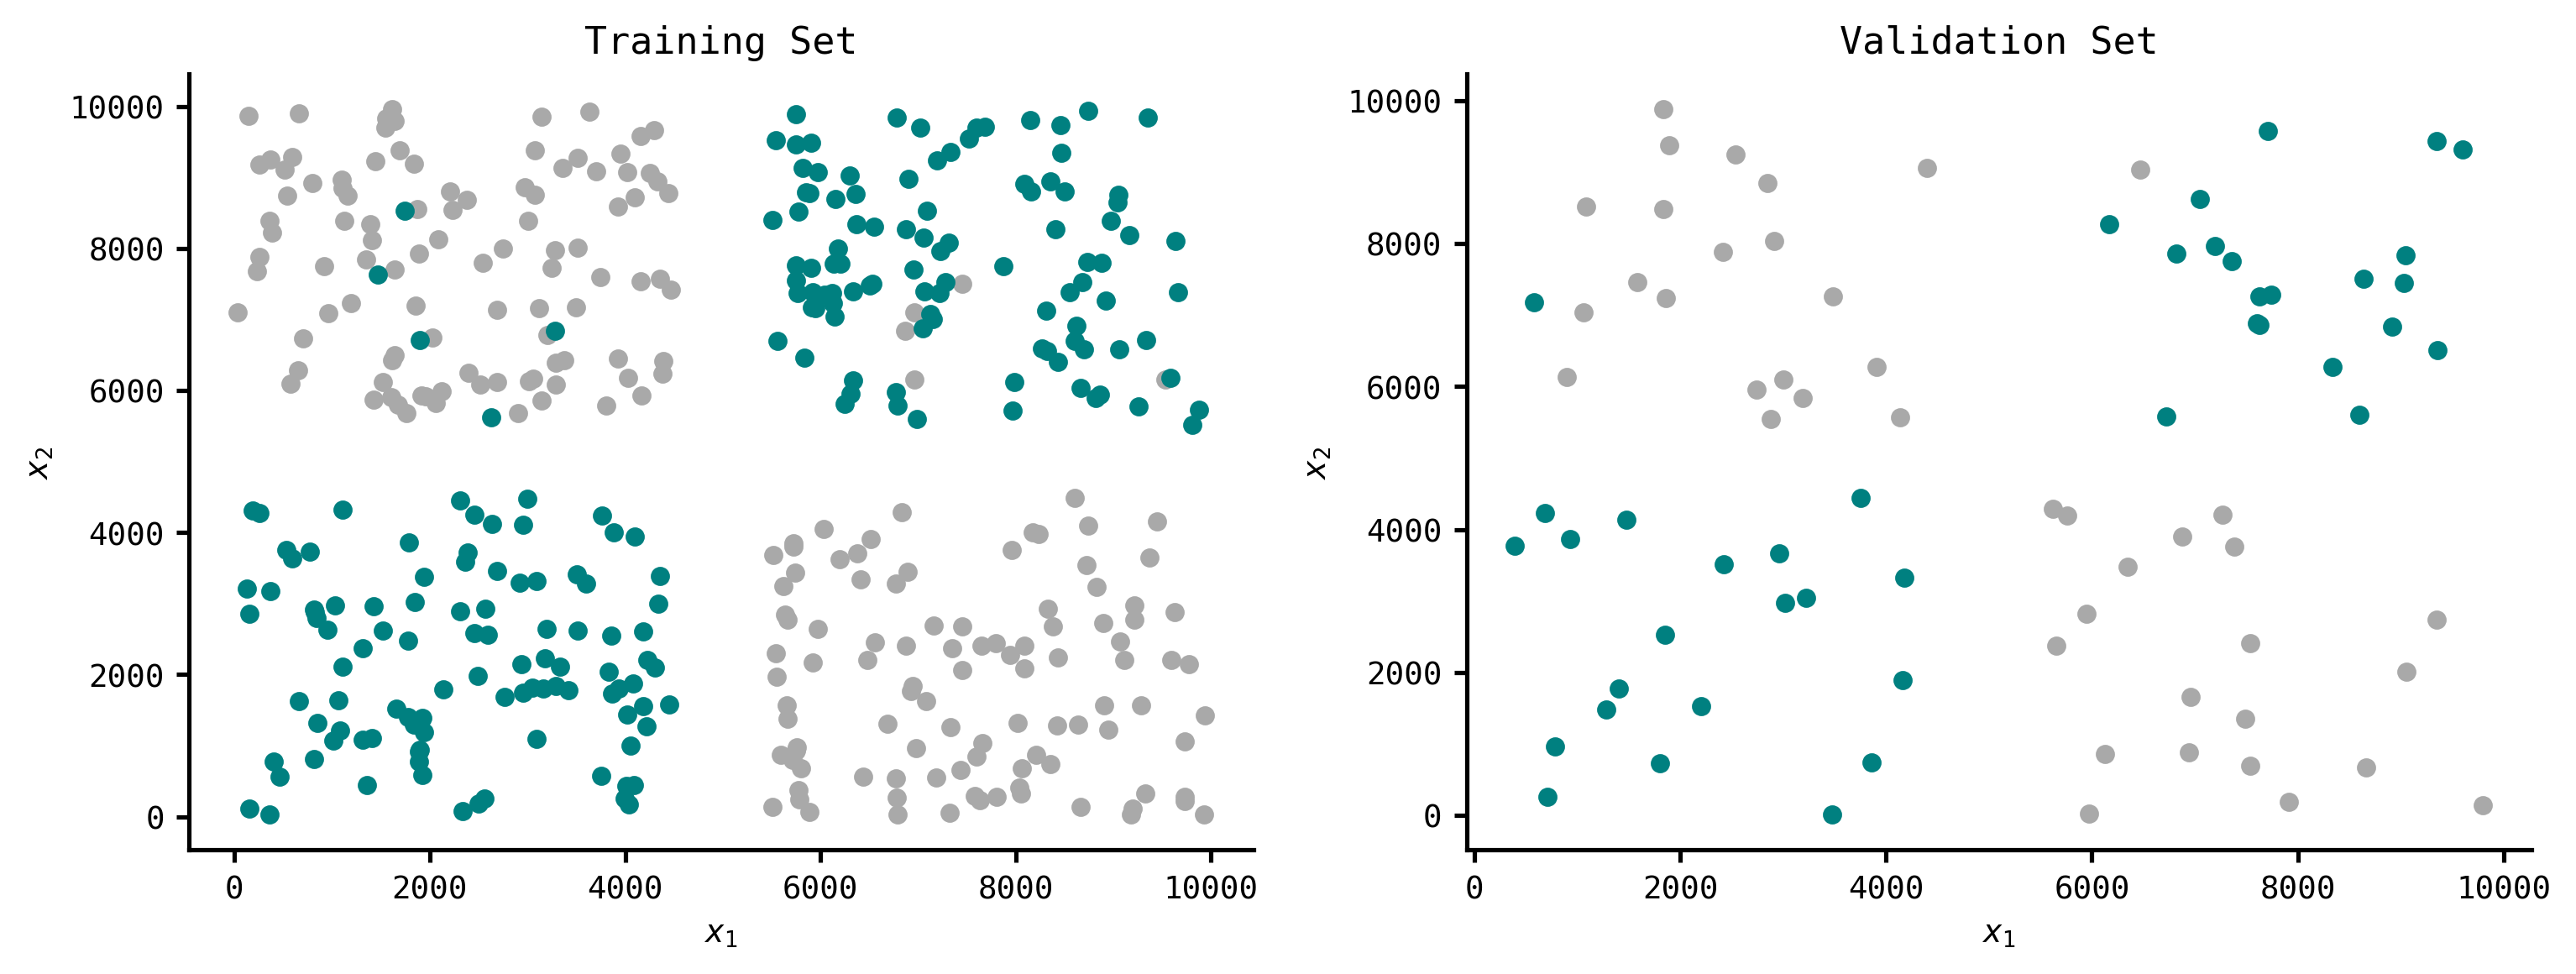

In [3]:
plt.figure(figsize=[12, 4], dpi=300)
ax1 = plt.subplot(1, 2, 1)
df_train[df_train.y.eq(1)].plot.scatter(x='x1', y='x2', c='darkgray', ax=ax1)
df_train[df_train.y.eq(0)].plot.scatter(x='x1', y='x2', c='teal', ax=ax1)
ax1.set_xlabel('$x_1$'); ax1.set_ylabel('$x_2$')
ax1.set_title('Training Set')
despine()
ax2 = plt.subplot(1, 2, 2)
df_val[df_val.y.eq(1)].plot.scatter(x='x1', y='x2', c='darkgray', ax=ax2)
df_val[df_val.y.eq(0)].plot.scatter(x='x1', y='x2', c='teal', ax=ax2)
ax2.set_xlabel('$x_1$'); ax2.set_ylabel('$x_2$')
ax2.set_title('Validation Set')
despine()
if output: plt.gcf().savefig('figures/pic1.png', dpi=300)

#### Data Normalisation, scale features:

In [4]:
def scaler(x, mean = None, variance = None):
    '''
    -> Zero-Mean Unit-Variance Scaler (standard scaler)
    '''
    if mean is None and variance is None:
        mean, variance = np.mean(x), np.std(x)
        return (x - mean)/variance, mean, variance
    else:
        return (x - mean)/variance

df_train['x1'], x1_mean, x1_var = scaler(df_train['x1'])
df_train['x2'], x2_mean, x2_var = scaler(df_train['x2'])
X_train, y_train = df_train[['x1','x2']], df_train['y']

df_val['x1'] = scaler(df_val['x1'], x1_mean, x1_var)
df_val['x2'] = scaler(df_val['x2'], x2_mean, x2_var)
X_val, y_val = df_val[['x1','x2']], df_val['y']

X_train, X_val = np.array(X_train).T, np.array(X_val).T
y_train, y_val = np.array(y_train).T, np.array(y_val).T

df_train[['x1','x2']].head(4)

,x1,x2
0,-0.692414,-0.540345
1,-1.052279,-1.345223
2,-0.247493,-1.097164
3,1.137351,1.550334


#### Test what production sklearn models achieve:

In [5]:
print("BENCHMARK:")
clf = SVC(kernel='rbf').fit(X_train.T, y_train.T)
print(f"Sklearn SVC Accuracy: {clf.score(X_val.T, y_val.T) :.3f}")

start = time.perf_counter()
mlp = MLPClassifier(hidden_layer_sizes = [10, 10],
                    activation = 'relu',
                    # solver = 'lbfgs',
                    learning_rate_init=0.01,
                    max_iter=200,
                    batch_size=10,
                    early_stopping = False,
                    momentum = False,
                    n_iter_no_change = 50, # to make sure it runs until max_iter
                    alpha = False,
                    verbose = False).fit(X_train.T, y_train.T)
end = time.perf_counter()

print(f"Sklearn MLP Accuracy: {mlp.score(X_val.T, y_val.T) :.3f}\nTime elapsed: {end-start :.2f}s")

BENCHMARK:
Sklearn SVC Accuracy: 0.976
Sklearn MLP Accuracy: 0.976
Time elapsed: 0.71s


/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Multi-layer Perceptron Neural Net from scratch:

In [6]:
# Hyperparameters:
LR = 0.01  # 'Learning Rate', starting values
BATCH_SIZE = 410/41
NUM_EPOCHS = 100

In [7]:
def compute_loss(predicted_op, y_true):
    ''''
    -> (Binary) Cross-Entropy Loss function
    *predicted_op is y_pred = sigmoid(h3)
    '''
    loss = 0
    for ii, value in enumerate(y_true):
            loss += - value*np.log(predicted_op[ii]) - (1-value)*np.log(1-predicted_op[ii])
    return loss/(y_true.size) # (average loss)

def loss_derivative(predicted_op, y_true):
    '''
    -> Derivative of (binary) cross-entropy loss function with respect to h3:
    loss_derivative = ∂L/∂y_pred * ∂y_pred/∂h3
                    = ∂CE/∂y_pred * ∂sigmoid/∂h3
                    = (y_pred - t)
                    *where t is the classification truth value 0/1
                    See proof at:
    https://towardsdatascience.com/how-does-back-propagation-work-in-neural-networks-with-worked-example-bc59dfb97f48
    '''
    return (predicted_op - y_true).reshape(1,-1)

In [8]:
def activation(x):
    '''
    -> ReLU Non-linear activation function
    '''
    return np.maximum(0, x)


def activation_derivative(x):
    '''
    -> Derivative of ReLU activation function
    * A Heaviside function with undefined value at x=0
    '''
    return np.heaviside(x, np.nan)

In [9]:
def sigmoid(x):
    ''' Sigmoid function to convert output into binary classification probability.
    '''
    return (1+np.exp(-x))**-1

def softmax(x):
    '''
    -> Softmax function to convert outputs into probabilites.
    '''
    softmax = np.array([[],[]])
    for ii in range(x.shape[-1]): # Iterate over columns
        new = np.exp(x[:, ii])/np.sum(np.exp(x[:, ii]))
        softmax = np.concatenate( (softmax, new.reshape(-1,1) ), axis = 1)
    return softmax


In [10]:
def initialise_net():
    '''
    -> Randomly initialise weights and biases in the range of [-1,1]
    '''
    W1 = 2*np.random.rand(10, 2) - 1
    W2 = 2*np.random.rand(10, 10) - 1
    W3 = 2*np.random.rand(1, 10) - 1
    b1 = 2*np.random.rand(10,1) - 1
    b2 = 2*np.random.rand(10,1) - 1
    b3 = 2*np.random.rand(1,1) - 1
    return [W1, W2, W3], [b1, b2, b3]

In [11]:
def forward_pass(X, W, b):
    '''
    -> Calculation of forward pass through the network

    *Initially coded in a simple form for one training example, now updated to do entire batch in matrix multiplication form. Rows are features/neurons, columns are for each data sample.
    Matrix dimensions:
    shape(X) = (2 features, n_samples)
    shape(W[0]) = (10 neurons, 2 inputs) # (it's actually W^T, to multiply with X)
    shape(h1) = (10, n_samples)
    shape(W[1]) = (10 neurons , 10 inputs)
    shape(h2) = (10, n_samples)
    shape(W[2]) = (1 neurons, 10 inputs)
    shape(h3) = (1, n_samples) ✅
    '''
    a1 = W[0] @ X + b[0]
    h1 = activation(a1)
    a2 = W[1] @ h1 + b[1]
    h2 = activation(a2)
    a3 = h3 = W[2] @ h2 + b[2] # no activation function on output layer
    y = sigmoid(h3)
    
    return y.ravel(), [a1, a2, a3], [h1, h2, h3]

In [12]:
def backward_pass(X, a, h, W, y_pred, y):
    '''
    Backpropagation of errors implementation
    * By dWi we mean the gradient of the loss function with respect to set of weights i ~ ∂L/∂Wi
    Matrix dimensions:
    dLdyi = {1,n}
    dW3 = {1,n}{n,10} = {1,10}
    da2 = {10,1}{1,n} .* {10,n}
    dW2 = {10,n}{n,10} = {10,10}
    da1 = {10,10}{10,n} .* {10,n}
    dW1 = {10,n}{n,2} = {10,2}
    '''
    dLdyi = loss_derivative(y_pred, y)

    dW3 = (1/y.size) * dLdyi @ h[1].T
    db3 = (1/y.size) * np.sum(dLdyi)

    da2 = W[2].T @ dLdyi * activation_derivative(a[1])
    dW2 = (1/y.size) * da2 @ h[0].T
    db2 = (1/y.size) * np.sum(da2)

    da1 = W[1].T @ da2 * activation_derivative(a[0])
    dW1 = (1/y.size) * da1 @ X.T
    db1 = (1/y.size) * np.sum(da1)

    return [dW1, dW2, dW3], [db1.reshape(-1,1), db2.reshape(-1,1), db3.reshape(-1,1)]

In [13]:
def update_weights(W, b, dW, db, lr):
    W[2] -= lr * dW[2]
    b[2] -= lr * db[2]
    W[1] -= lr * dW[1]
    b[1] -= lr * db[1]
    W[0] -= lr * dW[0]
    b[0] -= lr * db[0]
    return W, b

In [14]:
def make_batches(X, y, batch_size = BATCH_SIZE):
    '''
    Shuffles data and breaks into batches:
    '''
    data = np.vstack((X,y))
    np.random.shuffle(data.T)
    X, y = data[0:2,:], data[2,:]

    number_of_batches = int( X.shape[-1]/batch_size )
    X_batches, y_batches = [], []
    for displace in range(number_of_batches):
        X_batches += [ X[:,displace*batch_size:(displace+1)*batch_size] ]
        y_batches += [ y[displace*batch_size:(displace+1)*batch_size] ]
    return X_batches, y_batches

In [15]:
def stopping_criteria(it, num_epochs):
    while it < num_epochs:
        return False
    return True

In [16]:
def train(X_train, y_train, lr=LR, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, verbose=False, iter_indicator=5):
    '''
    Gradient-descent training of an MLP Neural Network through backpropagation and mini-batch SGD.
    '''
    it = 0

    W, b = initialise_net()

    while not stopping_criteria(it, num_epochs):
        # Break all training data into batches:
        X_batches, y_batches = make_batches(X_train, y_train, batch_size)

        for batch_number in range(len(X_batches)):
            X_batch, y_batch = X_batches[batch_number], y_batches[batch_number]

            # Forward the batch through the network layers:
            y_pred, a, h = forward_pass(X_batch, W, b)

            # Perform backward pass:
            dW, db = backward_pass(X_batch, a, h, W, y_pred, y_batch)

            # Update the weights and biases of the network:
            W, b = update_weights(W, b, dW, db, lr)

        # Compute the loss:
        loss = compute_loss(forward_pass(X_train, W, b)[0], y_train)

        if (it % iter_indicator == 0) and verbose:
            print(
                f"\nIteration: {it}\nCross Entropy Loss: {loss :.5f}\nLearning rate: {lr}")

        it += 1

    print(
        f"\nIteration: {it}\nCross Entropy Loss: {loss :.3f}\nLearning rate: {lr}")

    return W, b

In [17]:
def get_predictions(y_pred):
    return np.round(y_pred).astype(int)

def get_accuracy(predictions, y_true):
    return np.sum(predictions == y_true)/y_true.size

In [18]:
def plot_classifier(W, b):
    '''
    Single out and visualise those values where the MLP fails to classify correctly:
    '''
    h = 0.02  # step size
    x_min, x_max = X_train[0, :].min() - .5, X_train[0, :].max() + .5
    y_min, y_max = X_train[1, :].min() - .5, X_train[1, :].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_map = np.c_[xx.ravel(), yy.ravel()].T
    y_map, _, _ = forward_pass(X_map, W, b)
    y_map = get_predictions(y_map)
    y_map = y_map.reshape(xx.shape)

    y_pred_train, _, _ = forward_pass(X_train, W, b)
    y_pred_val, _, _ = forward_pass(X_val, W, b)

    plt.figure(figsize=[12, 4], dpi=300)
    ax1 = plt.subplot(1, 2, 1)
    ax1.contourf(xx, yy, y_map, levels=1, colors=['teal', 'darkgray'], alpha=0.25)
    problems = X_train[:, ~(get_predictions(y_pred_train) == y_train)]
    for ii in range(problems.shape[-1]):
        plt.scatter(problems[0, ii], problems[1, ii], c='orangered', alpha=0.5, s=50)
    df_train[df_train.y.eq(1)].plot.scatter(x='x1', y='x2', c='darkgray', ax=ax1)
    df_train[df_train.y.eq(0)].plot.scatter(x='x1', y='x2', c='teal', ax=ax1)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_title(
        f'Training Set | Accuracy {100*get_accuracy(get_predictions(y_pred_train), y_train) :.1f}%')
    despine()

    ax2 = plt.subplot(1, 2, 2)
    ax2.contourf(xx, yy, y_map, levels=1, colors=['teal', 'darkgray'], alpha=0.25)
    problems = X_val[:, ~(get_predictions(y_pred_val) == y_val)]
    for ii in range(problems.shape[-1]):
        plt.scatter(problems[0, ii], problems[1, ii], c='orangered', alpha=0.5, s=50)
    df_val[df_val.y.eq(1)].plot.scatter(x='x1', y='x2', c='darkgray', ax=ax2)
    df_val[df_val.y.eq(0)].plot.scatter(x='x1', y='x2', c='teal', ax=ax2)
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax2.set_title(
        f'Validation Set | Accuracy {100*get_accuracy(get_predictions(y_pred_val), y_val) :.1f}%')
    despine()

### Finally, train model and visualise:


Iteration: 100
Cross Entropy Loss: 0.131
Learning rate: 0.01
Batch size: 10
Time elapsed: 0.19s

Train Accuracy: 97.561% | Train Loss: 0.131
Validation Accuracy: 97.561% | Validation Loss: 0.142


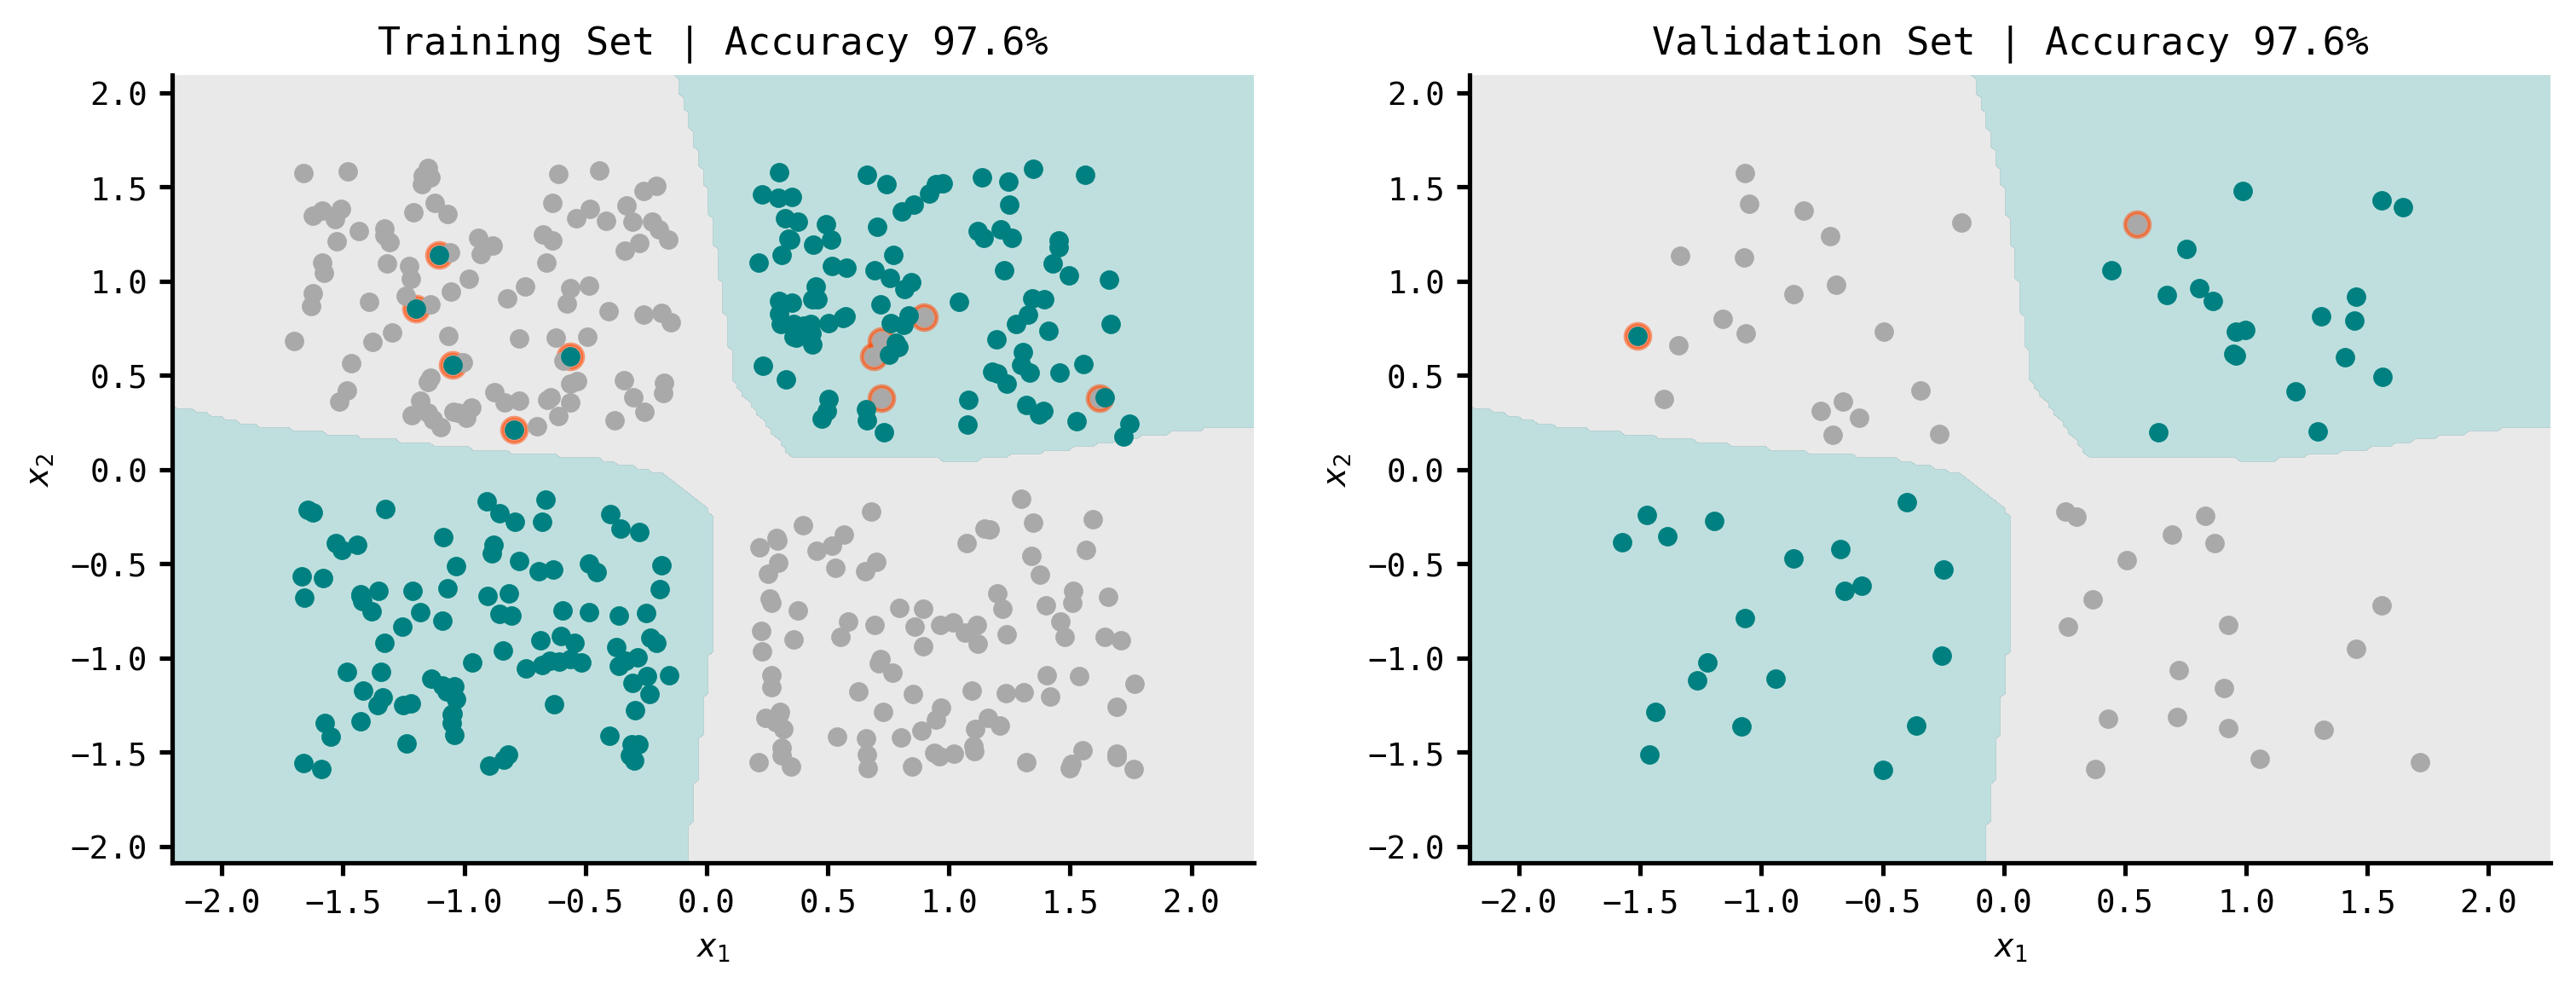

In [19]:
# Hyperparameters:
LR = 0.01  # 'Learning Rate, starting value'
BATCH_SIZE = int(410/41)
NUM_EPOCHS = 100

# Start timer:
start = time.perf_counter()

# Train:
W, b = train(X_train, y_train,
             lr=LR,
             batch_size=BATCH_SIZE,
             num_epochs=NUM_EPOCHS,
             iter_indicator=10,
             verbose=False)

end = time.perf_counter()

y_pred_train, _, _ = forward_pass(X_train, W, b)
print(f"Batch size: {BATCH_SIZE}\nTime elapsed: {end-start :.2f}s\n\nTrain Accuracy: {100*get_accuracy(get_predictions(y_pred_train), y_train) :.3f}% | Train Loss: {compute_loss(y_pred_train, y_train) :.3f}")

y_pred_val, _, _ = forward_pass(X_val, W, b)
print(f"Validation Accuracy: {100*get_accuracy(get_predictions(y_pred_val), y_val) :.3f}% | Validation Loss: {compute_loss(y_pred_val, y_val) :.3f}")

plot_classifier(W, b)
if output: plt.gcf().savefig('figures/pic3.png', dpi=300)

### Create confusion matrix:

In [20]:
def confusion_matrix(y_pred, y_true):
    '''
    Rows: True class
    Columns: Predicted
    '''
    y_pred, y_true = y_pred.astype(bool), y_true.astype(bool)
    zero_zero = np.sum(~y_pred[~y_true])
    zero_one = np.sum(y_pred[~y_true])
    one_zero = np.sum(~y_pred[y_true])
    one_one = np.sum(y_pred[y_true])
    return np.array([[zero_zero, zero_one],[one_zero, one_one]])

In [21]:
print('Training set confusion matrix:')
print(confusion_matrix(get_predictions(y_pred_train), y_train))

print('\nValidation set confusion matrix:')
print(confusion_matrix(get_predictions(y_pred_val), y_val))

Training set confusion matrix:
[[200   5]
 [  5 200]]

Validation set confusion matrix:
[[40  1]
 [ 1 40]]


### Modify training to plot progress over epoch:

In [22]:
def train_eval_over_iter(X_train, y_train, X_val, y_val, lr=LR, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS):

    loss_train, loss_val, accuracy_train, accuracy_val = [ [] for ii in range(4) ]

    it = 0
    W, b = initialise_net()

    while not stopping_criteria(it, num_epochs):
        X_batches, y_batches = make_batches(X_train, y_train, batch_size)

        for batch_number in range(len(X_batches)):
            X_batch, y_batch = X_batches[batch_number], y_batches[batch_number]
            y_pred, a, h = forward_pass(X_batch, W, b)
            dW, db = backward_pass(X_batch, a, h, W, y_pred, y_batch)
            W, b = update_weights(W, b, dW, db, lr)

        # Compute the loss and accuracy and store in lists:
        loss_train.append(compute_loss(forward_pass(X_train, W, b)[0], y_train))
        accuracy_train.append(100*get_accuracy( get_predictions(forward_pass(X_train, W, b)[0]), y_train))
        loss_val.append(compute_loss(forward_pass(X_val, W, b)[0], y_val))
        accuracy_val.append(100*get_accuracy( get_predictions(forward_pass(X_val, W, b)[0]), y_val))
        it += 1

    return W, b, loss_train, loss_val, accuracy_train, accuracy_val


In [23]:
def plot_eval_over_iter(loss_train, loss_val, accuracy_train, accuracy_val):
    plt.figure(figsize=[12, 4], dpi=300)
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(range(NUM_EPOCHS),loss_train, c='darkgray')
    plt.plot(range(NUM_EPOCHS),loss_val, c='teal')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.set_title('Cross-Entropy Loss over Training Epoch')
    ax1.set_ylim(0,0.8)
    plt.grid()
    despine()

    ax2 = plt.subplot(1, 2, 2)
    plt.plot(range(NUM_EPOCHS),accuracy_train, c='darkgray')
    plt.plot(range(NUM_EPOCHS),accuracy_val, c='teal')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy [%]')
    ax2.set_title('Accuracy over Training Epoch')
    ax2.set_ylim(45,100)
    plt.legend(['Training Set', 'Validation Set'], 
                bbox_to_anchor=(.96, .26, 0, 0),
                frameon=True, prop={'size': 8}, framealpha=1)
    plt.grid()
    despine()

    if output: plt.gcf().savefig('figures/pic4.png', dpi=300)

Train Accuracy: 97.561% | Train Loss: 0.128
Validation Accuracy: 97.561% | Validation Loss: 0.143


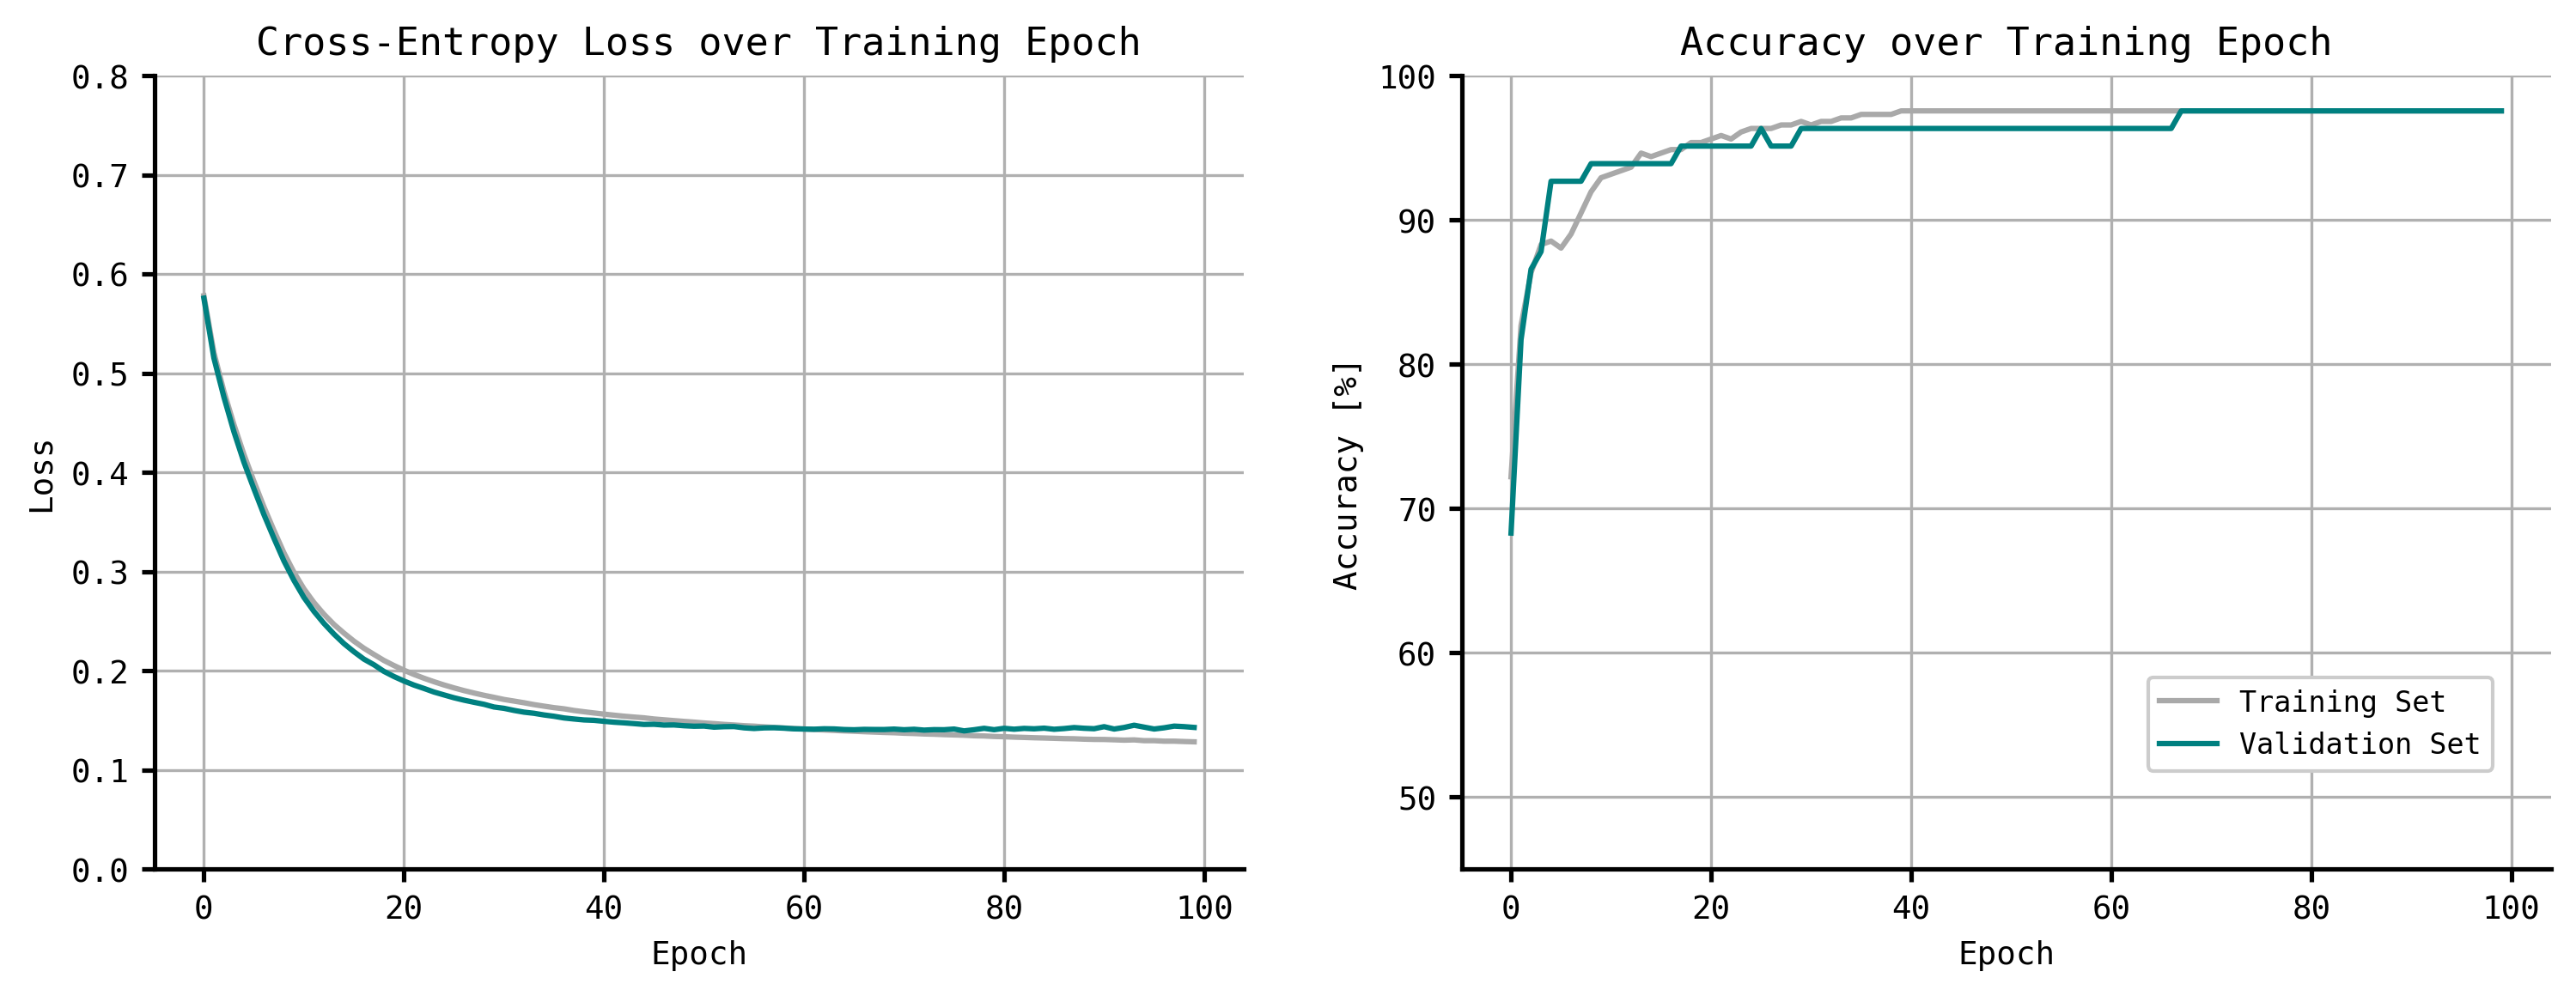

In [24]:
# Hyperparameters:
LR = 0.01  # 'Learning Rate, starting value'
BATCH_SIZE = int(410/41)
NUM_EPOCHS = 100

# Train:
W, b, loss_train, loss_val, accuracy_train, accuracy_val = train_eval_over_iter(X_train, y_train, X_val, y_val,
                                                                                lr=LR,
                                                                                batch_size=BATCH_SIZE,
                                                                                num_epochs=NUM_EPOCHS)

y_pred_train, _, _ = forward_pass(X_train, W, b)
print(f"Train Accuracy: {100*get_accuracy(get_predictions(y_pred_train), y_train) :.3f}% | Train Loss: {compute_loss(y_pred_train, y_train) :.3f}")
y_pred_val, _, _ = forward_pass(X_val, W, b)
print(f"Validation Accuracy: {100*get_accuracy(get_predictions(y_pred_val), y_val) :.3f}% | Validation Loss: {compute_loss(y_pred_val, y_val) :.3f}")

# plot_classifier(W, b)
plot_eval_over_iter(loss_train, loss_val, accuracy_train, accuracy_val)
if output: plt.gcf().savefig('figures/pic4.png', dpi=300)